# Stokes Problem - Channel Flow

This notebook implements a block FE solution of the following problem
$$
  \begin{cases}
    -μΔ𝐮 + ∇p = 0       & \quad \text{in } Ω \\
    ∇⋅𝐮 = 0             & \quad \text{in } Ω \\
    𝐮 = 0               & \quad \text{on } Γ_{\text wall} \\
    𝐮 = (1-y^2)𝐢 + 0𝐣    & \quad \text{on } Γ_{\text in} \\
    (∇𝐮 - pI)⋅ n = 0    & \quad \text{on } Γ_{\text out} \\
  \end{cases}
$$
 
given $Ω = [0,0] × [-1,1]$.

In [1]:
# Mesh generation
from mpi4py import MPI
import numpy as np
from dolfinx import mesh

h = 0.05
length = 2
R = 0.5
nx, ny = int(length/h), int(2 * R / h)
domain = mesh.create_rectangle(MPI.COMM_WORLD, [np.array([0, -R]), np.array([length, R])], 
                               [nx, ny], mesh.CellType.triangle)

# Define the functional space
gdim = domain.topology.dim

from dolfinx import fem
from dolfinx.fem import Function, FunctionSpace, dirichletbc, locate_dofs_topological, form
import ufl
from ufl import grad, div, nabla_grad, dx, inner, dot

P2 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 2)
P1 = ufl.FiniteElement("Lagrange", domain.ufl_cell(), 1)
V, Q = FunctionSpace(domain, P2), FunctionSpace(domain, P1)

# Define the face-tags for the BC
import dolfinx

fdim = gdim - 1

inlet_marker  = 10 
walls_marker  = 20
outlet_marker = 30

boundaries = [(inlet_marker,  lambda x: np.isclose(x[0], 0.)),
              (walls_marker,  lambda x: np.isclose(x[1], -R)),
              (walls_marker,  lambda x: np.isclose(x[1],  R)),
              (outlet_marker, lambda x: np.isclose(x[0], length))]

facet_indices, facet_markers = [], []
for (marker, locator) in boundaries:
    facets = dolfinx.mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full(len(facets), marker))
facet_indices = np.array(np.hstack(facet_indices), dtype=np.int32)
facet_markers = np.array(np.hstack(facet_markers), dtype=np.int32)
sorted_facets = np.argsort(facet_indices)
ft = dolfinx.mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

# Define the BC
from petsc4py import PETSc
## Inlet: parabolic velocity
def inlet_velocity_expression(x):
    values = np.zeros((gdim, x.shape[1]),dtype=PETSc.ScalarType)
    values[0] = 1-x[1]**2
    return values
in_velocity = Function(V)
in_velocity.interpolate(inlet_velocity_expression)
bc_in = dirichletbc(in_velocity, locate_dofs_topological(V, fdim, ft.find(inlet_marker)))

## Walls: no slip
noslip = np.zeros(domain.geometry.dim, dtype=PETSc.ScalarType)
bc_w = dirichletbc(noslip, locate_dofs_topological(V, fdim, ft.find(walls_marker)), V)

bcs = [bc_in, bc_w]

Let us define the functional spaces
$$
𝑉 = \{ 𝐯∈[ 𝑯^1(Ω) ]^2 : 𝐯|_{Γ_{in}} = 𝐮 \}
$$

In [2]:
(u, p) = ufl.TrialFunction(V), ufl.TrialFunction(Q)
(v, q) = ufl.TestFunction(V), ufl.TestFunction(Q)
f = fem.Constant(domain, (PETSc.ScalarType(0), PETSc.ScalarType(0)))
nu = fem.Constant(domain, PETSc.ScalarType(1e-3))

a = form([[nu * inner(grad(u), grad(v)) * dx, inner(p, div(v)) * dx],
          [inner(div(u), q) * dx, None]])
L = form([inner(f, v) * dx, inner(fem.Constant(domain, PETSc.ScalarType(0)), q) * dx])

# we will use a block-diagonal preconditioner to solve this problem
a_p = [[a[0][0], None],
       [None, form(inner(p, q) * dx)]]

## Block Iterative Solver

Let us assemble the matrices (the variable $A$ is the whole saddle point matrix)

In [3]:
A = fem.petsc.assemble_matrix_block(a, bcs=bcs)
A.assemble()
P = fem.petsc.assemble_matrix_block(a_p, bcs=bcs)
P.assemble()
b = fem.petsc.assemble_vector_block(L, a, bcs=bcs)

# Build IndexSets for each field (global dof indices for each field)
V_map = V.dofmap.index_map
Q_map = Q.dofmap.index_map
offset_u = V_map.local_range[0] * V.dofmap.index_map_bs + Q_map.local_range[0]
offset_p = offset_u + V_map.size_local * V.dofmap.index_map_bs
is_u = PETSc.IS().createStride(V_map.size_local * V.dofmap.index_map_bs, offset_u, 1, comm=PETSc.COMM_SELF)
is_p = PETSc.IS().createStride(Q_map.size_local, offset_p, 1, comm=PETSc.COMM_SELF)

# Create Krylov solver (iterative MINRES solver is used)
ksp = PETSc.KSP().create(domain.comm)
ksp.setOperators(A, P)
ksp.setTolerances(rtol=1e-9)
ksp.setType("minres")
ksp.getPC().setType("fieldsplit")
ksp.getPC().setFieldSplitType(PETSc.PC.CompositeType.ADDITIVE)
ksp.getPC().setFieldSplitIS(
    ("u", is_u),
    ("p", is_p))

# Configure velocity and pressure sub KSPs
ksp_u, ksp_p = ksp.getPC().getFieldSplitSubKSP()
ksp_u.setType("preonly")
ksp_u.getPC().setType("gamg")
ksp_p.setType("preonly")
ksp_p.getPC().setType("jacobi")

"""
# Monitor the convergence of the KSP
opts = PETSc.Options()
opts["ksp_monitor"] = None
opts["ksp_view"] = None
ksp.setFromOptions()
"""

'\n# Monitor the convergence of the KSP\nopts = PETSc.Options()\nopts["ksp_monitor"] = None\nopts["ksp_view"] = None\nksp.setFromOptions()\n'

We are now ready to actually solve the problem

In [4]:
# Compute solution
x = A.createVecRight()
ksp.solve(b, x)

# Create Functions and scatter x solution
u_, p_ = Function(V), Function(Q)
offset = V_map.size_local * V.dofmap.index_map_bs
u_.x.array[:offset] = x.array_r[:offset]
p_.x.array[:(len(x.array_r) - offset)] = x.array_r[offset:]

Let’s save the solution for a paraview plot

In [5]:
"""
from dolfinx.io import XDMFFile

with XDMFFile(domain.comm, "velocity.xdmf", "w") as loc:
    loc.write_mesh(domain)
    u_.name = "U"
    loc.write_function(u_)

with XDMFFile(domain.comm, "pressure.xdmf", "w") as loc:
    loc.write_mesh(domain)
    p_.name = "p"
    loc.write_function(p_)
"""

'\nfrom dolfinx.io import XDMFFile\n\nwith XDMFFile(domain.comm, "velocity.xdmf", "w") as loc:\n    loc.write_mesh(domain)\n    u_.name = "U"\n    loc.write_function(u_)\n\nwith XDMFFile(domain.comm, "pressure.xdmf", "w") as loc:\n    loc.write_mesh(domain)\n    p_.name = "p"\n    loc.write_function(p_)\n'

Let us make some plots using matplotlib

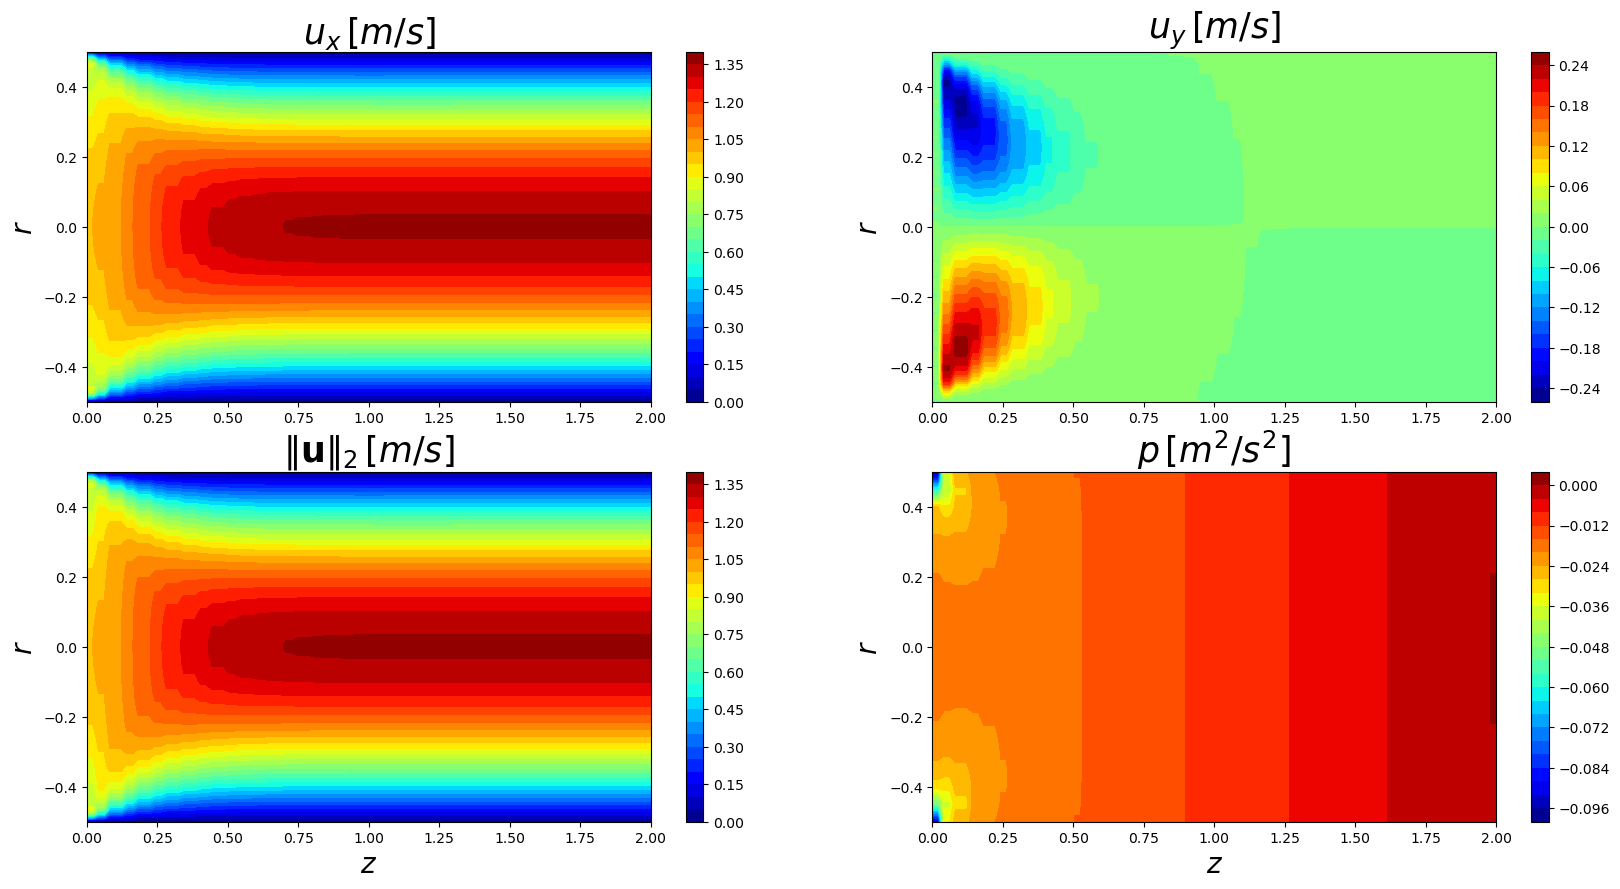

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
from scipy.interpolate import NearestNDInterpolator

# plt.rcParams.update({
#   "text.usetex": True,
#   "font.family": "serif"
# })

# rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

def extractVectorField(domain, xBound, yBound, u_):
    Nx, Ny = 40, 100
    x_grid = np.linspace(xBound[0], xBound[1], Nx)
    y_grid = np.linspace(yBound[0], yBound[1], Ny)
    
    u_x = np.zeros((Nx, Ny))
    u_y = np.zeros_like(u_x)

    for ii in range(Nx):
        points = np.zeros((3, Ny))
        points[0, :] = x_grid[ii]
        points[1, :] = y_grid

        bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
        cells = []
        points_on_proc = []
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
        colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i))>0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        xPlot = np.array(points_on_proc, dtype=np.float64)

        u_x[ii, :] = u_.eval(xPlot, cells)[:, 0]
        u_y[ii, :] = u_.eval(xPlot, cells)[:, 1]

    u_x_grid = np.zeros((Nx * Ny,))
    u_y_grid = np.zeros_like(u_x_grid)
    x_y_grid = np.zeros((Nx * Ny, 2))

    idx = 0

    for ii in range(Nx):
        for jj in range(Ny):
            u_x_grid[idx] = u_x[ii, jj]
            u_y_grid[idx] = u_y[ii, jj]

            x_y_grid[idx, 0] = x_grid[ii]
            x_y_grid[idx, 1] = y_grid[jj]

            idx += 1

    return NearestNDInterpolator(x_y_grid, u_x_grid), NearestNDInterpolator(x_y_grid, u_y_grid)

def extractScalarField(domain, xBound, yBound, p_):
    Nx, Ny = 40, 100
    x_grid = np.linspace(xBound[0], xBound[1], Nx)
    y_grid = np.linspace(yBound[0], yBound[1], Ny)
    
    p_matri = np.zeros((Nx, Ny))

    for ii in range(Nx):
        points = np.zeros((3, Ny))
        points[0, :] = x_grid[ii]
        points[1, :] = y_grid

        bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
        cells = []
        points_on_proc = []
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
        colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i))>0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        xPlot = np.array(points_on_proc, dtype=np.float64)

        p_matri[ii, :] = p_.eval(xPlot, cells).flatten()

    p_grid = np.zeros((Nx * Ny,))
    x_y_grid = np.zeros((Nx * Ny, 2))

    idx = 0

    for ii in range(Nx):
        for jj in range(Ny):
            p_grid[idx] = p_matri[ii, jj]

            x_y_grid[idx, 0] = x_grid[ii]
            x_y_grid[idx, 1] = y_grid[jj]

            idx += 1

    return NearestNDInterpolator(x_y_grid, p_grid)

xBound = np.array([0., length])
yBound = np.array([-R, R])
ux_fun, uy_fun = extractVectorField(domain, xBound, yBound, u_)
p_fun = extractScalarField(domain, xBound, yBound, p_)

################################################################################

xPlot = np.linspace(xBound[0], xBound[1], 100)
yPlot = np.linspace(yBound[0], yBound[1], 100)

X, Y = np.meshgrid(xPlot, yPlot)

_figure = plt.figure( figsize = (20,10) )
plt.subplot(2,2,1)
plt.contourf(X, Y, ux_fun(X,Y), cmap=cm.jet, levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.title(r'$u_x\,[m/s]$', fontsize = 25)
                         
plt.subplot(2,2,2)
plt.contourf(X, Y, uy_fun(X,Y), cmap=cm.jet, levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.title(r'$u_y\,[m/s]$', fontsize = 25)

plt.subplot(2,2,3)
plt.contourf(X, Y, np.sqrt(ux_fun(X,Y)**2 + uy_fun(X,Y)**2), cmap=cm.jet, levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.xlabel(r'$z$', fontsize = 20)
plt.title(r'$\|\mathbf{u}\|_2\,[m/s]$', fontsize = 25)

plt.subplot(2,2,4)
plt.contourf(X, Y, p_fun(X,Y), cmap=cm.jet, levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.xlabel(r'$z$', fontsize = 20)
plt.title(r'$p\,[m^2/s^2]$', fontsize = 25)

# _figure.savefig('Stokes_blockIterative.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.savefig('Stokes_blockIterative.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

## Block Direct Solver

Let us assemble the matrices (the variable $A$ is the whole saddle point matrix)

In [7]:
# Create LU solver
ksp = PETSc.KSP().create(domain.comm)
ksp.setOperators(A)
ksp.setType("preonly")
ksp.getPC().setType("lu")
ksp.getPC().setFactorSolverType("superlu_dist")

We are now ready to actually solve the problem

In [8]:
# Compute solution
x = A.createVecLeft()
ksp.solve(b, x)

# Create Functions and scatter x solution
u_, p_ = Function(V), Function(Q)
offset = V_map.size_local * V.dofmap.index_map_bs
u_.x.array[:offset] = x.array_r[:offset]
p_.x.array[:(len(x.array_r) - offset)] = x.array_r[offset:]

Let us make some plots using matplotlib

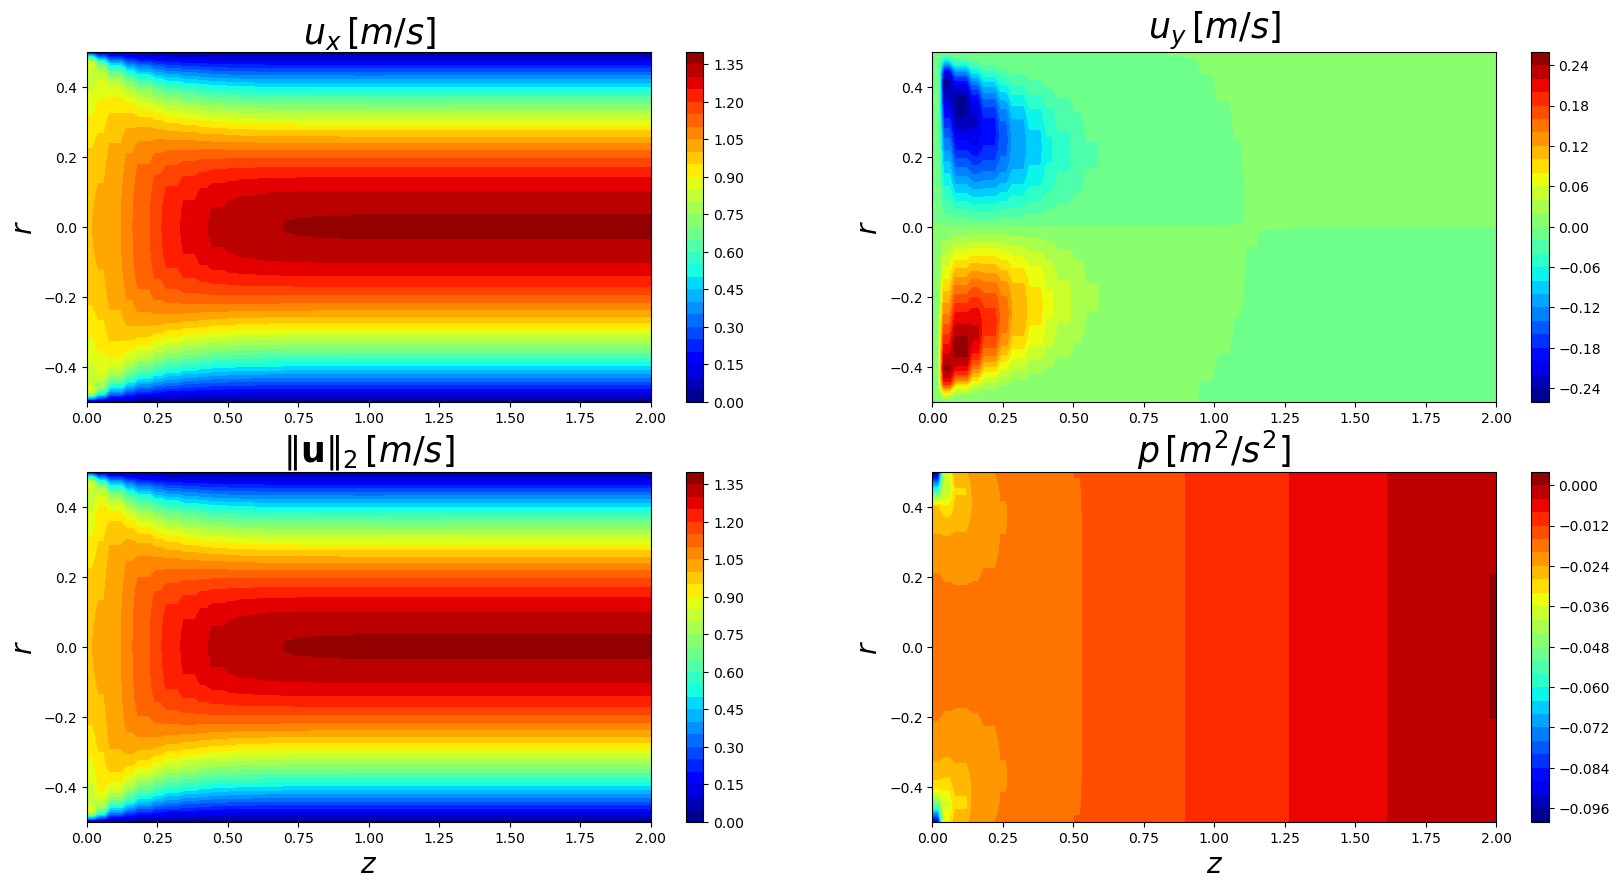

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
from scipy.interpolate import NearestNDInterpolator

# plt.rcParams.update({
#   "text.usetex": True,
#   "font.family": "serif"
# })

# rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

def extractVectorField(domain, xBound, yBound, u_):
    Nx, Ny = 40, 100
    x_grid = np.linspace(xBound[0], xBound[1], Nx)
    y_grid = np.linspace(yBound[0], yBound[1], Ny)
    
    u_x = np.zeros((Nx, Ny))
    u_y = np.zeros_like(u_x)

    for ii in range(Nx):
        points = np.zeros((3, Ny))
        points[0, :] = x_grid[ii]
        points[1, :] = y_grid

        bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
        cells = []
        points_on_proc = []
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
        colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i))>0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        xPlot = np.array(points_on_proc, dtype=np.float64)

        u_x[ii, :] = u_.eval(xPlot, cells)[:, 0]
        u_y[ii, :] = u_.eval(xPlot, cells)[:, 1]

    u_x_grid = np.zeros((Nx * Ny,))
    u_y_grid = np.zeros_like(u_x_grid)
    x_y_grid = np.zeros((Nx * Ny, 2))

    idx = 0

    for ii in range(Nx):
        for jj in range(Ny):
            u_x_grid[idx] = u_x[ii, jj]
            u_y_grid[idx] = u_y[ii, jj]

            x_y_grid[idx, 0] = x_grid[ii]
            x_y_grid[idx, 1] = y_grid[jj]

            idx += 1

    return NearestNDInterpolator(x_y_grid, u_x_grid), NearestNDInterpolator(x_y_grid, u_y_grid)

def extractScalarField(domain, xBound, yBound, p_):
    Nx, Ny = 40, 100
    x_grid = np.linspace(xBound[0], xBound[1], Nx)
    y_grid = np.linspace(yBound[0], yBound[1], Ny)
    
    p_matri = np.zeros((Nx, Ny))

    for ii in range(Nx):
        points = np.zeros((3, Ny))
        points[0, :] = x_grid[ii]
        points[1, :] = y_grid

        bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
        cells = []
        points_on_proc = []
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
        colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i))>0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        xPlot = np.array(points_on_proc, dtype=np.float64)

        p_matri[ii, :] = p_.eval(xPlot, cells).flatten()

    p_grid = np.zeros((Nx * Ny,))
    x_y_grid = np.zeros((Nx * Ny, 2))

    idx = 0

    for ii in range(Nx):
        for jj in range(Ny):
            p_grid[idx] = p_matri[ii, jj]

            x_y_grid[idx, 0] = x_grid[ii]
            x_y_grid[idx, 1] = y_grid[jj]

            idx += 1

    return NearestNDInterpolator(x_y_grid, p_grid)

xBound = np.array([0., length])
yBound = np.array([-R, R])
ux_fun, uy_fun = extractVectorField(domain, xBound, yBound, u_)
p_fun = extractScalarField(domain, xBound, yBound, p_)

##############################################################################

xPlot = np.linspace(xBound[0], xBound[1], 100)
yPlot = np.linspace(yBound[0], yBound[1], 100)

X, Y = np.meshgrid(xPlot, yPlot)

_figure = plt.figure( figsize = (20,10) )
plt.subplot(2,2,1)
plt.contourf(X, Y, ux_fun(X,Y), cmap=cm.jet, levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.title(r'$u_x\,[m/s]$', fontsize = 25)
                         
plt.subplot(2,2,2)
plt.contourf(X, Y, uy_fun(X,Y), cmap=cm.jet, levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.title(r'$u_y\,[m/s]$', fontsize = 25)

plt.subplot(2,2,3)
plt.contourf(X, Y, np.sqrt(ux_fun(X,Y)**2 + uy_fun(X,Y)**2), cmap=cm.jet, levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.xlabel(r'$z$', fontsize = 20)
plt.title(r'$\|\mathbf{u}\|_2\,[m/s]$', fontsize = 25)

plt.subplot(2,2,4)
plt.contourf(X, Y, p_fun(X,Y), cmap=cm.jet, levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.xlabel(r'$z$', fontsize = 20)
plt.title(r'$p\,[m^2/s^2]$', fontsize = 25)

# _figure.savefig('Stokes_blockDirect.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.savefig('Stokes_blockDirect.png', format='png', dpi=600, bbox_inches='tight')
plt.show()